In [33]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
col_names = ["unit_no","time","os1","os2","os3"] + [f'sm{i}' for i in range(1,22)] 
col_names

['unit_no',
 'time',
 'os1',
 'os2',
 'os3',
 'sm1',
 'sm2',
 'sm3',
 'sm4',
 'sm5',
 'sm6',
 'sm7',
 'sm8',
 'sm9',
 'sm10',
 'sm11',
 'sm12',
 'sm13',
 'sm14',
 'sm15',
 'sm16',
 'sm17',
 'sm18',
 'sm19',
 'sm20',
 'sm21']

In [93]:
fd_001_train = pd.read_csv("/home/lazyguy/Downloads/project_ell409 (2)/Turbofan-engine-RUL-prediction-master/CMAPSSData/train_FD001_normed.txt",sep=" ",header=None,names=col_names,index_col=False)
fd_001_test = pd.read_csv("/home/lazyguy/Downloads/project_ell409 (2)/Turbofan-engine-RUL-prediction-master/CMAPSSData/test_FD001_normed.txt",sep=" ",header=None,names=col_names,index_col=False)
y_fd_001_test = pd.read_csv('/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/RUL_FD001.txt' , header=None , names=['rul'] )
fd_001_train.describe()

,unit_no,time,os1,os2,os3,sm1,sm2,sm3,sm4,sm5,sm6,sm7,sm8,sm9,sm10,sm11,sm12,sm13,sm14,sm15,sm16,sm17,sm18,sm19,sm20,sm21
count,20631.000000,20631.000000,20631.0,20631.0,20631.0,20631.0,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,0.0,0.0,0.0,0.0,0.447425,0.430177,0.438319,0.0,0.980321,0.562179,0.325939,0.196856,0.0,0.414507,0.577576,0.326360,0.220448,0.458828,0.0,0.436127,0.0,0.0,0.545425,0.541677
std,29.227633,68.880990,0.0,0.0,0.0,0.0,0.156430,0.143088,0.167719,0.0,0.138898,0.166339,0.136664,0.106815,0.0,0.165611,0.166763,0.129940,0.103861,0.154905,0.0,0.157636,0.0,0.0,0.156451,0.159678
min,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
25%,26.000000,52.000000,0.0,0.0,0.0,0.0,0.335366,0.330447,0.315610,0.0,1.000000,0.455426,0.229508,0.136699,0.0,0.294479,0.473318,0.235294,0.162103,0.347268,0.0,0.333333,0.0,0.0,0.446429,0.441566
50%,52.000000,104.000000,0.0,0.0,0.0,0.0,0.435976,0.420314,0.423092,0.0,1.000000,0.576998,0.311475,0.174546,0.0,0.398773,0.593023,0.312500,0.202860,0.444950,0.0,0.444444,0.0,0.0,0.553571,0.553872
75%,77.000000,156.000000,0.0,0.0,0.0,0.0,0.547541,0.520114,0.543370,0.0,1.000000,0.682171,0.404255,0.219586,0.0,0.515337,0.699571,0.400000,0.247653,0.554998,0.0,0.545455,0.0,0.0,0.653543,0.654843
max,100.000000,362.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,1.000000


Some features have very low standard deviation as we can see. So we drop these.

In [89]:
to_drop = []
for col in fd_001_train.columns:
    if(abs(fd_001_train[col].std()) < 0.02):
        to_drop += [col]
fd_001_train.drop(columns=to_drop,inplace=True)

RUL is calculated for training data using the "time" column as the data has been given till engine failure.

In [90]:
y_fd_001 = fd_001_train.groupby('unit_no')['time'].transform('max') - fd_001_train['time']

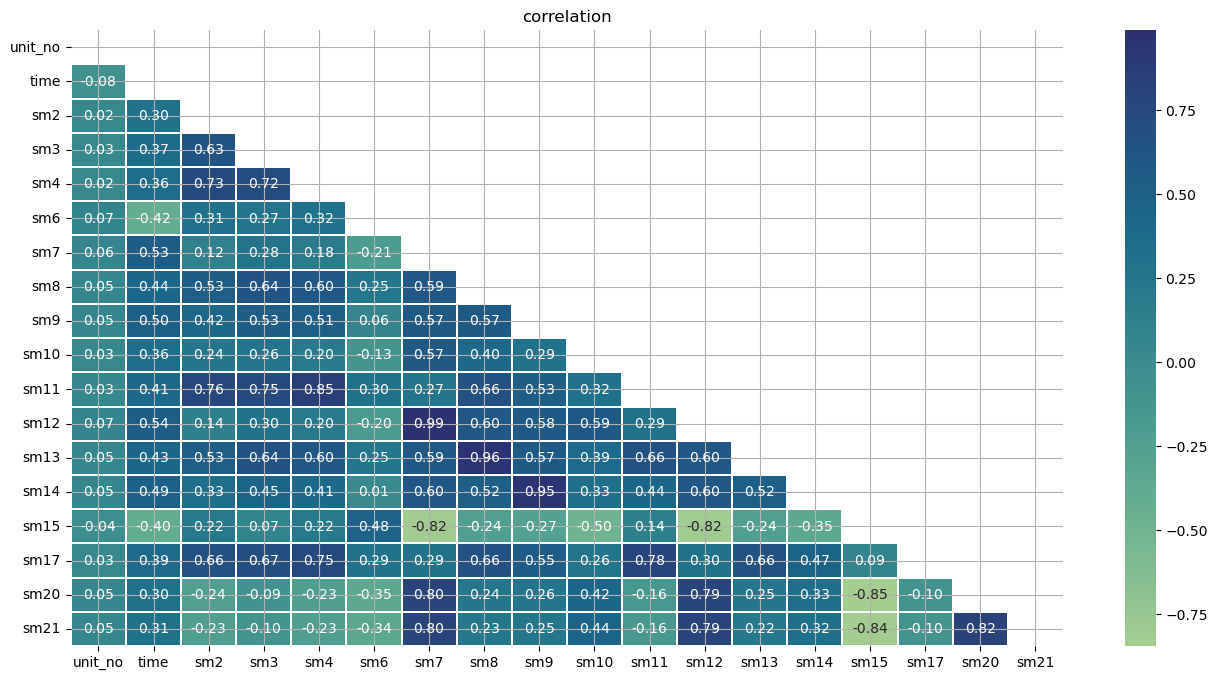

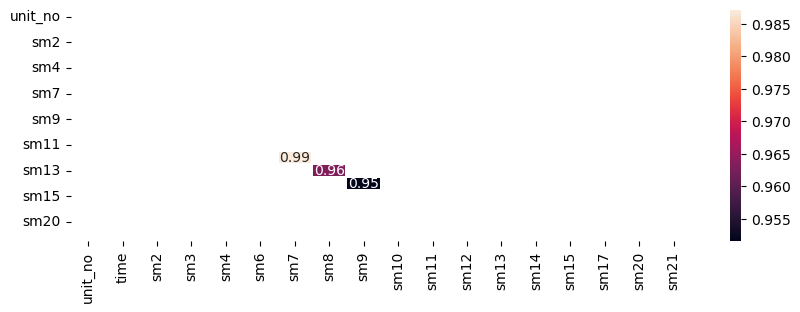

In [91]:
def find_correlations(df):
    mask = np.triu(np.ones(df.shape).astype(bool))
    df_corr = df.corr()
    mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
    df_corr = df_corr.where(mask)
    plt.figure(figsize = (16,8))
    plt.grid() , plt.title('correlation')
    sns.heatmap(df_corr , annot=True , fmt = '0.2f' , cmap='crest' , linewidths=0.01)
    plt.figure(figsize = (10,3))
    mask = df_corr.where( abs(df_corr) > 0.95 ).isna()
    sns.heatmap(df_corr , annot=True , fmt = '0.2f' , linewidths=0.1 , mask = mask )
    high_corr = []
    for col in df_corr.columns:
        for row in df_corr.index:
            if abs(df_corr.loc[col , row]) > 0.95 :
                high_corr.append((row , col))
    return high_corr

high_corr = find_correlations(fd_001_train)

We drop one of the features in the highly correlated features

In [83]:
to_drop = [pair[0] for pair in high_corr]
fd_001_train.drop(columns = to_drop , inplace = True) #sm9 for fd001, sm7,8,9 for fd003
fd_001_train.describe()

,unit_no,time,sm2,sm3,sm4,sm6,sm7,sm8,sm11,sm12,sm13,sm14,sm15,sm17,sm20,sm21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,0.447425,0.430177,0.438319,0.980321,0.562179,0.325939,0.414507,0.577576,0.326360,0.220448,0.458828,0.436127,0.545425,0.541677
std,29.227633,68.880990,0.156430,0.143088,0.167719,0.138898,0.166339,0.136664,0.165611,0.166763,0.129940,0.103861,0.154905,0.157636,0.156451,0.159678
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,52.000000,0.335366,0.330447,0.315610,1.000000,0.455426,0.229508,0.294479,0.473318,0.235294,0.162103,0.347268,0.333333,0.446429,0.441566
50%,52.000000,104.000000,0.435976,0.420314,0.423092,1.000000,0.576998,0.311475,0.398773,0.593023,0.312500,0.202860,0.444950,0.444444,0.553571,0.553872
75%,77.000000,156.000000,0.547541,0.520114,0.543370,1.000000,0.682171,0.404255,0.515337,0.699571,0.400000,0.247653,0.554998,0.545455,0.653543,0.654843
max,100.000000,362.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


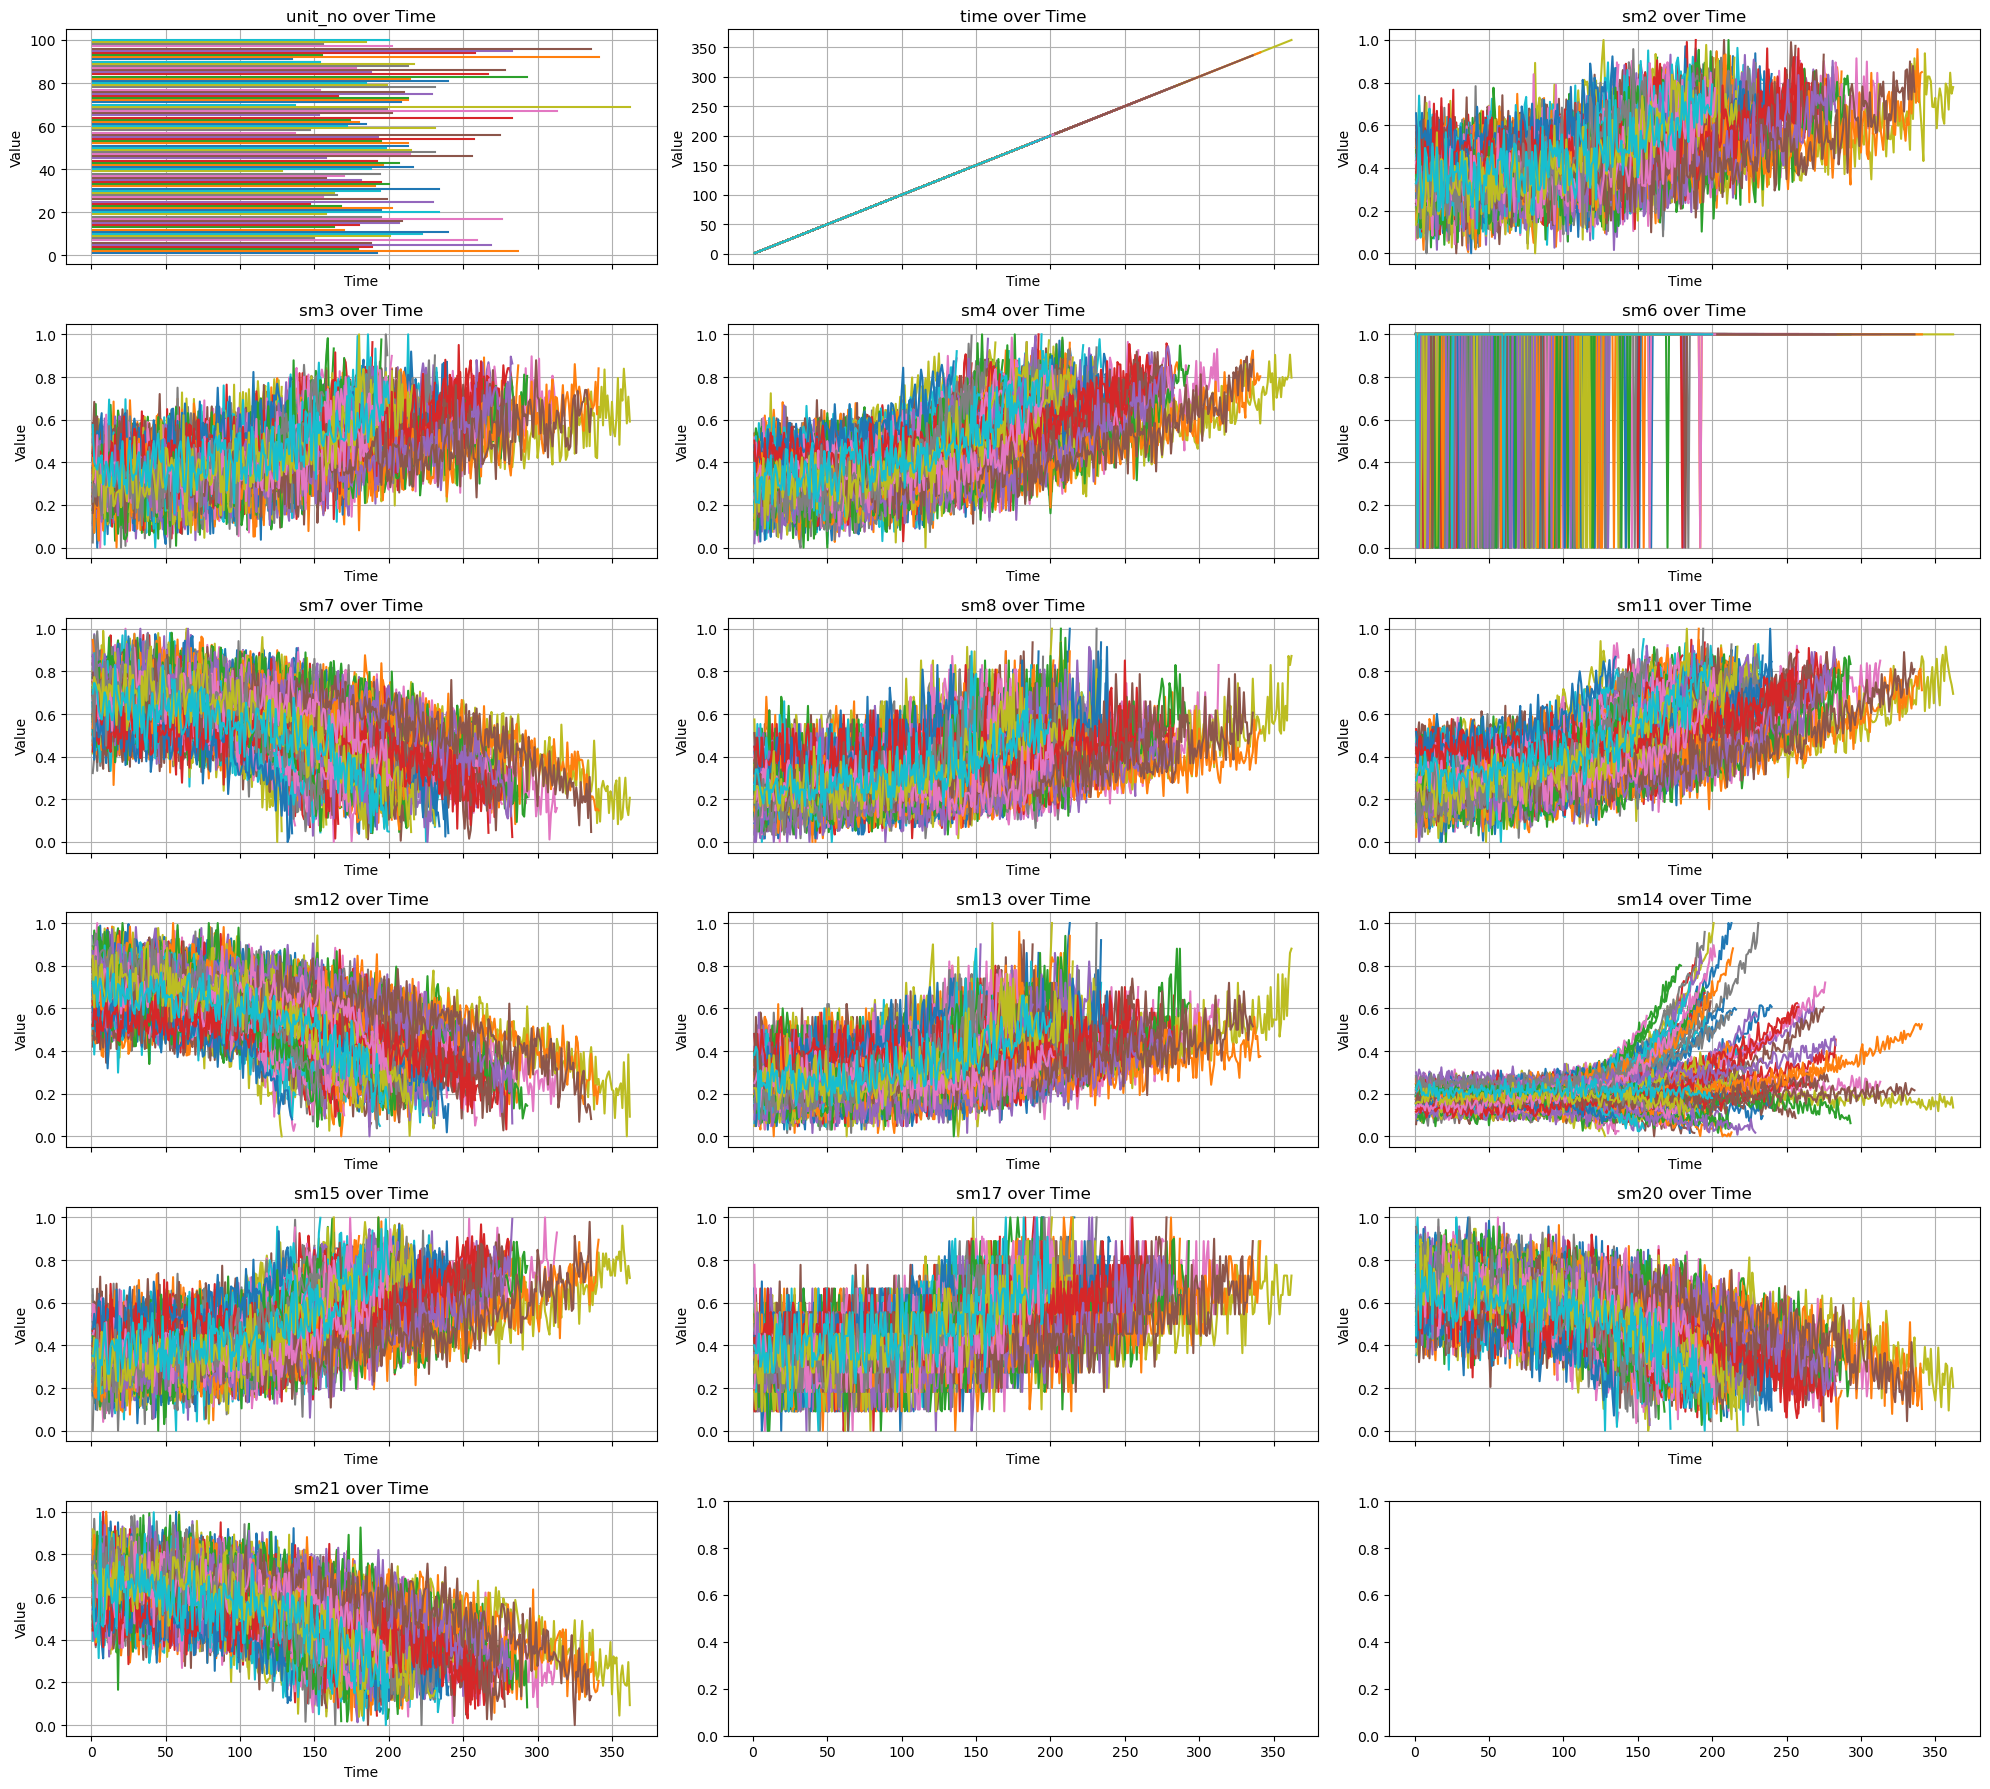

In [84]:
def plot_features(df):
    engines_to_plot = range(1, 101)  # Engine numbers from 1 to 100
    columns_to_plot = df.columns

    # The list contains all the setting and sensor columns
    num_columns = 3
    num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns  # 计算行数
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 3), sharex=True)

#     Iterate over each engine number and plot the lines
    for engine_number in engines_to_plot:
        engine_data = df[df['unit_no'] == engine_number]
        for ax, column in zip(axes.flatten(), columns_to_plot):
            ax.plot(engine_data['time'], engine_data[column])

    # Setting up titles, labels and grids for subgraphs
    for ax, column in zip(axes.flatten(), columns_to_plot):
        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
#         ax.legend(loc='upper right')
        ax.grid(True)

    # Adjust the layout so that subgraphs do not overlap
    plt.tight_layout()
    plt.show()
# df = pd.read_csv("/home/lazyguy/Downloads/project_ell409 (2)/Turbofan-engine-RUL-prediction-master/CMAPSSData/train_FD002_normed.txt",sep=" ",header=None,names=col_names,index_col=False)
plot_features(fd_001_train)
fd_001_train.drop(columns="time",inplace=True)

As we can see there is some trend in the features with time, which is a good thing. Now we try to train on the dataset formed.

In [ ]:
# Apply rolling mean for all columns, grouped by 'unit_no'
df_rolling = fd_001_train.groupby('unit_no').rolling(window=5).mean()

# Reset the index to align it with the original DataFrame
df_rolling = df_rolling.reset_index(drop=True)

# Ensure the result has the same shape by filling NaN values (from the first rows in each group)
df_rolling_filled = df_rolling.fillna(0)  # or fillna(0) if you want to replace NaNs with 0

# Add the rolling mean columns back to the original DataFrame with new column names
df_rolling_filled.columns = [f'rolling_mean_{col}' for col in df_rolling_filled.columns]  # Rename columns
fd_001_train = pd.concat([fd_001_train, df_rolling_filled], axis=1)

df_rolling = fd_001_test.groupby('unit_no').rolling(window=10).mean()

# Reset the index to align it with the original DataFrame
df_rolling = df_rolling.reset_index(drop=True)

# Ensure the result has the same shape by filling NaN values (from the first rows in each group)
df_rolling_filled = df_rolling.fillna(0)  # or fillna(0) if you want to replace NaNs with 0

# Add the rolling mean columns back to the original DataFrame with new column names
df_rolling_filled.columns = [f'rolling_mean_{col}' for col in df_rolling_filled.columns]  # Rename columns
fd_001_test = pd.concat([fd_001_test, df_rolling_filled], axis=1)



In [85]:
features = fd_001_train.columns[1:]
features

Index(['sm2', 'sm3', 'sm4', 'sm6', 'sm7', 'sm8', 'sm11', 'sm12', 'sm13',
       'sm14', 'sm15', 'sm17', 'sm20', 'sm21'],
      dtype='object')

In [86]:
# train set
from sklearn.model_selection import train_test_split
X = fd_001_train[features]

X_train , X_val , y_train , y_val  = train_test_split(X, y_fd_001, test_size=0.2 , random_state=42)


To form the test data we take only the final datapoint of each engine available in the testing dataset, for which RUL values are given in a separate file.

In [87]:
X_test = fd_001_test.groupby('unit_no').last().reset_index()
X_test = X_test[features]
y_test = y_fd_001_test["rul"].to_numpy()
X.shape , X_test.shape , X_val.shape

((20631, 14), (100, 14), (4127, 14))

MinMax Scaling used since not all features are gaussian.

In [46]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train)      # fit on only train dataset

X_test = scaler.transform(X_test)            # use same transofrmation , no fit_traansform
X_val = scaler.transform(X_val)

In [13]:
with open("results.txt","w") as obj:
    pass


In [47]:
from sklearn.metrics import root_mean_squared_error , r2_score 
import math
def eval_metrics(y_true , y_pred , label = 'train'):
    '''evaluate model , by taking y_true , y_pred and label of dataset'''
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/13) - 1   
        else:
            score += math.exp(- i/10) - 1
        
    rmse = root_mean_squared_error(y_true , y_pred)
    r2 = r2_score(y_true , y_pred)
    print(f'for {label} set , RMSE = {rmse:0.2f} , r2_score = {r2*100:0.2f}%, score = {score/len(y_pred)} \n')
    with open("results.txt","a") as obj:
        obj.write(f'for {label} set , RMSE = {rmse:0.2f} , r2_score = {r2*100:0.2f}%, score = {score/len(y_pred)} \n')
    return score

In [48]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
model_linreg = Ridge()
model_linreg.fit(X_train , y_train.clip(upper=120))
with open("results.txt","a") as obj:
    obj.write("Ridge Regression \n")
y_pred = model_linreg.predict(X_train)
# print(y_train.shape,y_pred.shape)
eval_metrics(y_train.clip(upper=120) , y_pred , label = 'train')

y_pred = model_linreg.predict(X_val)
# print(y_val.shape,y_pred.shape)
eval_metrics(y_val.clip(upper=120), y_pred , label = 'val')

y_pred = model_linreg.predict(X_test)
eval_metrics(y_test.reshape(-1) , y_pred , label = 'test')

for train set , RMSE = 20.76 , r2_score = 72.90%, score = 8.950697428884991 

for val set , RMSE = 20.88 , r2_score = 72.39%, score = 8.997667684015099 

for test set , RMSE = 33.36 , r2_score = 61.52%, score = 662.5726917635845 



171606.3271667684

In [49]:
from sklearn.tree import DecisionTreeRegressor
model_tree = DecisionTreeRegressor(random_state=42,min_samples_split=5,min_samples_leaf=5,max_depth=9)
model_tree.fit(X_train , y_train.clip(upper=120))
with open("results.txt","a") as obj:
    obj.write("Decision Tree \n")

y_pred = model_tree.predict(X_train)
eval_metrics(y_train.clip(upper=120), y_pred , label = 'train')

y_pred = model_tree.predict(X_val)
eval_metrics(y_val.clip(upper=120), y_pred , 'val')

y_pred = model_tree.predict(X_test)
eval_metrics(y_test , y_pred , label = 'test')

for train set , RMSE = 18.37 , r2_score = 78.77%, score = 7.827370402526673 

for val set , RMSE = 20.36 , r2_score = 73.74%, score = 14.390929862728264 

for test set , RMSE = 31.75 , r2_score = 65.15%, score = 482.61549738551275 



124997.4138228478

In [50]:
from sklearn.ensemble import RandomForestRegressor
model_forest = RandomForestRegressor(random_state=42 , n_jobs=-1 )

# model_forest.fit(X_train , y_train.clip(upper=120))

# y_pred = model_forest.predict(X_train)
# eval_metrics(y_train.clip(upper=120) , y_pred , label = 'train')

# y_pred = model_forest.predict(X_val)
# eval_metrics(y_val.clip(upper=120) , y_pred , 'val')

# y_pred = model_forest.predict(X_test)

# eval_metrics(y_test , y_pred , label = 'test')

In [51]:
%%time
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from scipy.stats import randint
RandomForestRegressor()
param ={
    'max_depth' : [5*i for i in range(1,41)] , 
    'min_samples_split' : [5*i for i in range(1,41)] , 
    'min_samples_leaf' : [5*i for i in range(1,41)]
} 
random_search_forest = RandomizedSearchCV(estimator=model_forest , param_distributions=param , n_iter=10 ,
                  cv = 5 , scoring = 'r2' , random_state=42 , n_jobs=-1)
random_search_forest.fit(X_train , y_train.clip(upper=120))

CPU times: user 54.9 s, sys: 265 ms, total: 55.1 s
Wall time: 1min 51s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30, 35,
                                                      40, 45, 50, 55, 60, 65,
                                                      70, 75, 80, 85, 90, 95,
                                                      100, 105, 110, 115, 120,
                                                      125, 130, 135, 140, 145,
                                                      150, ...],
                                        'min_samples_leaf': [5, 10, 15, 20, 25,
                                                             30, 35, 40, 45, 50,
                                                             55, 60, 65, 70, 75,
                                                             80, 85, 90, 95,
                                                             100, 105, 110, 115,
                                                             120, 125, 130, 135,
                                                             140, 145, 150, ...],
                                        'min_samples_split': [5, 10, 15, 20, 25,
                                                              30, 35, 40, 45,
                                                              50, 55, 60, 65,
                                                              70, 75, 80, 85,
                                                              90, 95, 100, 105,
                                                              110, 115, 120,
                                                              125, 130, 135,
                                                              140, 145, 150, ...]},
                   random_state=42, scoring='r2')

In [22]:
df_res_forest = pd.DataFrame(random_search_forest.cv_results_).sort_values('mean_test_score')
df_res_forest[['mean_test_score' , 'params']]

,mean_test_score,params
2,0.604709,"{'min_samples_split': 105, 'min_samples_leaf':..."
5,0.612075,"{'min_samples_split': 120, 'min_samples_leaf':..."
6,0.612075,"{'min_samples_split': 65, 'min_samples_leaf': ..."
9,0.613252,"{'min_samples_split': 130, 'min_samples_leaf':..."
1,0.614626,"{'min_samples_split': 180, 'min_samples_leaf':..."
3,0.615114,"{'min_samples_split': 195, 'min_samples_leaf':..."
8,0.628894,"{'min_samples_split': 35, 'min_samples_leaf': ..."
0,0.629998,"{'min_samples_split': 115, 'min_samples_leaf':..."
4,0.634478,"{'min_samples_split': 55, 'min_samples_leaf': ..."
7,0.635179,"{'min_samples_split': 25, 'min_samples_leaf': ..."


In [52]:
# val score for random forest final model
model_fine_forest = random_search_forest.best_estimator_
print(model_fine_forest)
with open("results.txt","a") as obj:
    obj.write("Random Forest \n")
y_pred = model_fine_forest.predict(X_train)
eval_metrics(y_train.clip(upper=120), y_pred, label = 'train')

y_pred = model_fine_forest.predict(X_val)
eval_metrics(y_val.clip(upper=120), y_pred, label = 'val')

y_pred = model_fine_forest.predict(X_test)
eval_metrics(y_test.reshape(-1) , y_pred, label = 'test')

RandomForestRegressor(max_depth=40, min_samples_leaf=15, min_samples_split=25,
                      n_jobs=-1, random_state=42)
for train set , RMSE = 15.39 , r2_score = 85.10%, score = 4.259277060075996 

for val set , RMSE = 18.75 , r2_score = 77.72%, score = 8.928910217962915 

for test set , RMSE = 30.59 , r2_score = 67.65%, score = 330.90272586437294 



85703.80599887259

Text(0.5, 1.0, 'random forest model')

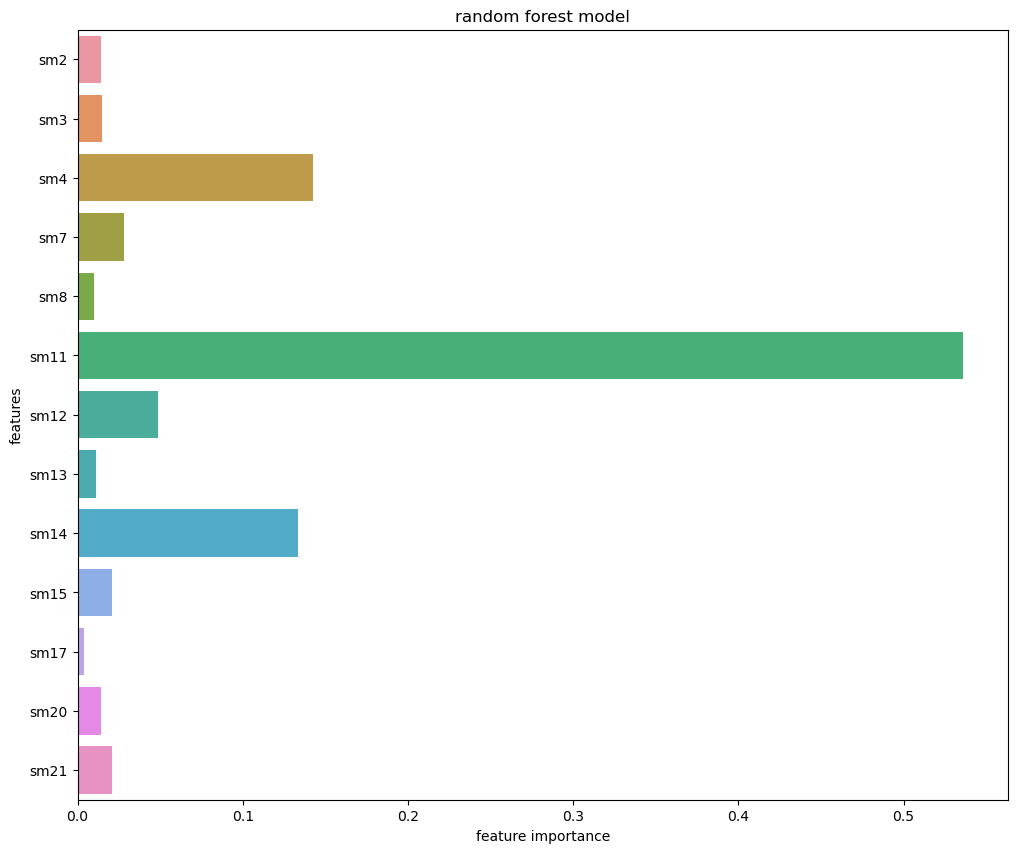

In [25]:
import seaborn as sns
plt.figure(figsize = (12,10))
sns.barplot(y = features , x = model_fine_forest.feature_importances_ )
plt.xlabel('feature importance')
plt.ylabel('features')
plt.title('random forest model')

In [22]:
%%time
from sklearn.svm import SVR
model_svm = SVR(C=20)
# model_svm.fit(X_train , y_train.clip(upper=120))
# y_pred = model_svm.predict(X_train)
# eval_metrics(y_train.clip(upper=120), y_pred , label = 'train')
# y_pred = model_svm.predict(X_val)
# eval_metrics(y_val.clip(upper=120), y_pred , 'val')
# y_pred = model_svm.predict(X_test)
# eval_metrics(y_test , y_pred , label = 'test')

CPU times: user 23 µs, sys: 9 µs, total: 32 µs
Wall time: 33.6 µs


In [23]:
%%time
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from scipy.stats import randint , uniform   # it returen range of dist , not single value like np.random.randint
model_svm = SVR()
param_grid = {
    'C': [5,10,15,20,30], 
    'kernel': ['rbf'],
    'gamma' : ['scale']
    }
random_search_svm = GridSearchCV(estimator=model_svm , param_grid=param_grid ,
                                 cv = 5, scoring = 'r2' , n_jobs=-1)
random_search_svm.fit(X_train , y_train.clip(upper=120))

CPU times: user 1min 9s, sys: 541 ms, total: 1min 10s
Wall time: 5min 55s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [5, 10, 15, 20, 30], 'gamma': ['scale'],
                         'kernel': ['rbf']},
             scoring='r2')

In [28]:
df_svm = pd.DataFrame(random_search_svm.cv_results_)
df_svm[['mean_test_score' , 'params']].sort_values(by = 'mean_test_score' , ascending=False)

,mean_test_score,params
3,0.628245,"{'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}"
4,0.628242,"{'C': 30, 'gamma': 'scale', 'kernel': 'rbf'}"
2,0.628168,"{'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}"
1,0.627580,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"
0,0.625957,"{'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}"


In [25]:
# val score for SVM final model
model_fine_svm = random_search_svm.best_estimator_
print(model_fine_svm)
with open("results.txt","a") as obj:
    obj.write("SVM R \n")
y_pred = model_fine_svm.predict(X_train)
eval_metrics(y_train.clip(upper=120), y_pred, label = 'train')

y_pred = model_fine_svm.predict(X_val)
eval_metrics(y_val.clip(upper=120), y_pred, label = 'val')

y_pred = model_fine_svm.predict(X_test)
eval_metrics(y_test , y_pred, label = 'test')

SVR(C=30)
for train set , RMSE = 29.36 , r2_score = 45.78%, score = 29.0931286692857 

for val set , RMSE = 29.31 , r2_score = 45.58%, score = 29.311888258599932 

for test set , RMSE = 42.57 , r2_score = 37.33%, score = 1573.0790555346755 



407427.47538348095

In [26]:
%%time
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators = 20 , max_depth = 6, learning_rate = 0.1 , 
                 reg_lambda = 0.02 , gamma = 0.4 , random_state = 42 )
# model_xgb.fit(X_train , y_train )

# y_pred = model_xgb.predict(X_train)
# eval_metrics(y_train.clip(upper=120), y_pred , label = 'train')

# y_pred = model_xgb.predict(X_val)
# eval_metrics(y_val.clip(upper=120), y_pred , 'val')

# y_pred = model_xgb.predict(X_test)
# eval_metrics(y_test , y_pred , label = 'test')

CPU times: user 17.1 ms, sys: 18 ms, total: 35 ms
Wall time: 74.7 ms


In [27]:
%%time
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from scipy.stats import randint , uniform   # it returen range of dist , not single value like np.random.randint

model_xgb = xgb.XGBRegressor()
param_distributions = {
    'n_estimators': randint(50, 500),  # Number of boosting rounds (trees)
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinking to prevent overfitting
    'max_depth': randint(3, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight needed in a child
    'subsample': uniform(0.5, 0.5),  # Subsample ratio of the training instances
    'colsample_bytree': uniform(0.5, 0.5),  # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 5),  # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),  # L1 regularization term on weights
    'reg_lambda': uniform(0, 1)  # L2 regularization term on weights
}
random_search_xgb = RandomizedSearchCV(estimator=model_xgb , param_distributions=param_distributions ,
                                   n_iter=10 , cv = 5 , scoring = 'r2' , random_state=42 , n_jobs=-1)
random_search_xgb.fit(X_train , y_train.clip(upper=120))

CPU times: user 4.35 s, sys: 193 ms, total: 4.54 s
Wall time: 9.08 s


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x75a91aa3df10>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x75a9c3d06c10>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x75a9c3d07190>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x75a9c3d05d10>},
                   random_state=42, scoring='r2')

In [ ]:
df_xgb = pd.DataFrame(random_search_xgb.cv_results_)
df_xgb[['mean_test_score' , 'params']].sort_values(by = 'mean_test_score' , ascending=False)

In [28]:
model_fine_xgb = random_search_xgb.best_estimator_
print(model_fine_xgb)
y_pred = model_fine_xgb.predict(X_train)
eval_metrics(y_train.clip(upper=120), y_pred , label = 'train')

y_pred = model_fine_xgb.predict(X_val)
eval_metrics(y_val.clip(upper=120), y_pred , 'val')

y_pred = model_fine_xgb.predict(X_test)
eval_metrics(y_test , y_pred , label = 'test')

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8037724259507192, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.8526206184364576,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.029515477895583855,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=365, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
for train set , RMSE = 26.83 , r2_score = 54.73%, score = 38.49360450063025 

for val set , RMSE = 27.51 , r2_score = 52.04%, score = 48.392896185435106 

for test set , RMSE = 39.70 , r2_score = 45.50%,

226043.60869849412

In [ ]:
y_pred = model_fine_svm.predict(X_22)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_22, label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_fine_svm.predict(X_39)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_39, label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_fine_svm.predict(X_69)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_69, label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define model parameters
win_length = 25      # Sliding Window Length
feature_num = 13     # Total number of features

# Define the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
        # Flatten layer
        self.flatten = nn.Flatten()
        # Fully connected layer
        self.fc = nn.Linear(32 * (win_length - 4) * (feature_num - 4), 1)  # Calculate the input size after Conv2D

    def forward(self, x):
        # Apply first Conv2D layer with ReLU
        x = F.relu(self.conv1(x))
        # Apply second Conv2D layer with ReLU
        x = F.relu(self.conv2(x))
        # Flatten the output
        x = self.flatten(x)
        # Fully connected layer
        x = self.fc(x)
        return x

# Instantiate the model
model = CNNModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)


In [ ]:
def prepare_sliding_window_data(df, win_length=10, batch_size=32):
    # Filter for the specific unit
    X_train,y_train
    for unit_no in range(1,101):
        df_unit = df[df['unit_no'] == unit_no]

        # Separate unit_no column and scale the rest
        unit_no_column = df_unit[['unit_no']].values  # Keep unit_no as separate array
        features = df_unit.drop(columns=['unit_no'])  # Drop unit_no for scaling

        # Apply MinMaxScaler on the feature columns
#         scaler = MinMaxScaler()
#         features_scaled = scaler.fit_transform(features)
        print(f'Scaled features for unit {unit_no}, shape: {features_scaled.shape}')

        # Split into sliding windows
        X, y = [], []
        for i in range(len(features_scaled) - win_length):
            X.append(features_scaled[i:i + win_length])   # Window of features
            y.append(features_scaled[i + win_length, -1]) # Target is the last column after the window

    # Convert to numpy arrays and reshape for PyTorch
    X = np.array(X).reshape(-1, win_length, features_scaled.shape[1], 1)  # Add channel dimension
    y = np.array(y)


In [32]:
from sklearn.preprocessing import MinMaxScaler
df_train = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/train_FD002.txt",sep=" ",header=None,names=col_names,index_col=False)
df_test = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/test_FD002.txt",sep=" ",header=None,names=col_names,index_col=False)
y_test = pd.read_csv('/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/RUL_FD002.txt' , header=None , names=['rul'] )
def add_operating_condition(df_op_cond):
    
    df_op_cond['os1'] = df_op_cond['os1'].round()
    df_op_cond['os2'] = df_op_cond['os2'].round(decimals=2)
    
    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['os1'].astype(str) + '_' + df_op_cond['os2'].astype(str) + '_' + df_op_cond['os3'].astype(str)
    return df_op_cond

df_train = add_operating_condition(df_train)
df_test = add_operating_condition(df_test)
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = MinMaxScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
#     le = LabelEncoder()
#     df_train["op_cond"] = le.fit_transform(df_train["op_cond"])
#     df_test["op_cond"] = le.transform(df_test["op_cond"])
    df_train = df_train.drop(columns="op_cond")
    df_test = df_test.drop(columns= "op_cond")
    return df_train, df_test
df_train,df_test =  condition_scaler(df_train,df_test,col_names[2:])
# to_drop = []
# for col in col_names:
#     if(abs(df_train[col].std()) < 0.02):
#         to_drop += [col]
# df_train = df_train.drop(columns=to_drop)
# df_train["rul"] = df_train.groupby('unit_no')['time'].transform('max') - df_train['time']
file_path = 'train_FD002_normed.txt'
df_train.to_csv(file_path, sep=' ', index=False, header=False)
df_test.to_csv("test_FD002_normed.txt",sep = " ",index=False,header=False)

/tmp/ipykernel_5129/1339404952.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_train = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/train_FD002.txt",sep=" ",header=None,names=col_names,index_col=False)
/tmp/ipykernel_5129/1339404952.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df_test = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/test_FD002.txt",sep=" ",header=None,names=col_names,index_col=False)
/tmp/ipykernel_5129/1339404952.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.4 0.2 0.4 ... 0.5 0.7 0.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']=

In [ ]:
X = df_train.drop(columns = ["unit_no","time"])
X = X.to_numpy()
y = y.to_numpy()
y = y.clip(max=120)
X_train , X_val , y_train , y_val  = train_test_split(X, y, test_size=0.2 , random_state=42)
X_test = df_test.groupby('unit_no').last().reset_index()
X_test = X_test[df_train.drop(columns = ["unit_no","time"]).columns].to_numpy()
y_test = y_test.to_numpy()

In [ ]:
df_train

In [ ]:
X,y = [],[]
for unit_no in range(1,261):
    df_unit = df_train[df_train["unit_no"]==unit_no]
    features = df_unit.drop(columns = ["unit_no","rul","time"]).to_numpy()
    ruls = df_unit["rul"].to_numpy()
    for i in range(len(features)-20):
        X.append(features[i:i+20])
        y.append(ruls[i+20-1])

In [ ]:
df_train = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/train_FD001.txt",sep=" ",header=None,names=col_names,index_col=False)
df_test = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/test_FD001.txt",sep=" ",header=None,names=col_names,index_col=False)
y_test = pd.read_csv('/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/RUL_FD001.txt' , header=None , names=['rul'] )
to_drop = []
for col in df_train.columns:
    if(abs(df_train[col].std()) < 0.02):
        to_drop += [col]
df_train = df_train.drop(columns=to_drop)
df_train["rul"] = df_train.groupby('unit_no')['time'].transform('max') - df_train['time']
df_train = df_train.drop(columns = ['sm9','time']) #sm9 for fd001,none for fd002, sm7,8,9 for fd003
def scale_columns(df, columns_to_scale):
    """Scale specified columns in the DataFrame and update the original DataFrame."""
    # Initialize the scaler
    scaler = MinMaxScaler()
    
    # Fit and transform the specified columns
    df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    # Return the scaler for potential future use
    return scaler
scaler = scale_columns(df_train,df_train.drop(columns = ["unit_no","rul"]).columns)
X,y = [],[]
for unit_no in range(1,101):
    df_unit = df_train[df_train["unit_no"]==unit_no]
    features = df_unit.drop(columns = ["unit_no","rul"]).to_numpy()
    ruls = df_unit["rul"].to_numpy()
    for i in range(len(features)-25):
        X.append(features[i:i+25])
        y.append(ruls[i+25-1])


In [ ]:
X = np.array(X)
y = np.array(y)
y = y.clip(max=120)
X_train , X_val , y_train , y_val  = train_test_split(X, y, test_size=0.2 , random_state=42)

In [ ]:
cols_feat = df_train.drop(columns = ["rul","time"]).columns
df_test = df_test[cols_feat]
# df_test[df_train.drop(columns = ["unit_no","rul","time"]).columns] = scaler.transform(df_test[df_train.drop(columns = ["unit_no","rul","time"]).columns])
X_test = []
print(df_test.shape)
for unit_no in range(1,len(y_test)+1):
    df_unit = df_test[df_test["unit_no"]==unit_no]
    features = df_unit.drop(columns = ["unit_no"]).to_numpy()
    X_test.append(features[-20:])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
fd = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/test_FD002.txt",sep=" ",header=None,names=col_names,index_col=False)
fd["rul"] = fd.groupby('unit_no')['time'].transform('max') - fd['time']
fd = fd.groupby('unit_no').first().reset_index()
fd.describe()

In [ ]:
df_test = pd.read_csv("/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/test_FD001.txt",sep=" ",header=None,names=col_names,index_col=False)
df_test = df_test[df_train.drop(columns = ["rul"]).columns]
cols_scal = df_train.drop(columns = ["unit_no","rul"]).columns
df_test[cols_scal] = scaler.transform(df_test[cols_scal])
df_test

In [ ]:
X_69,y_69 = [],[]
df_unit = df_train[df_train["unit_no"]==22]
features = df_unit.drop(columns = ["unit_no","rul"]).to_numpy()
ruls = df_unit["rul"].to_numpy()
for i in range(len(features)-25):
    X_69.append(features[i:i+25])
    y_69.append(ruls[i+25-1])
X_69 = np.array(X_69)
y_69 = np.array(y_69)

In [ ]:
y_test.shape

In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    outputs = model(torch.tensor(X_69,dtype=torch.float32).unsqueeze(1))
    y_pred = outputs.numpy()
    rmse = root_mean_squared_error(y_69.clip(max=120) , y_pred)
    r2 = r2_score(y_69 , y_pred)
    print(f'for {"test"} set , RMSE = {rmse**2:0.2f} , r2_score = {r2*100:0.2f}%, score = {y_pred.shape}')
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(y_pred)),
                y=y_69.clip(max=120).flatten(),
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(y_pred)),
                y=y_pred.flatten(),
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

In [ ]:
X_train.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
mini = 1e9
idx = -1
X_test_ten = torch.tensor(X_test,dtype=torch.float32).unsqueeze(1)
for see in range(0,101,5):
    torch.manual_seed(see)
    # Convert NumPy arrays to PyTorch tensors
    def numpy_to_dataloader(x_data, y_data, batch_size=32, shuffle=True):
        x_tensor = torch.tensor(x_data, dtype=torch.float32)
        y_tensor = torch.tensor(y_data, dtype=torch.float32)
        dataset = TensorDataset(x_tensor, y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # Example PyTorch model (you can replace it with your own)
    class SimpleCNN(nn.Module):
        def __init__(self, input_channels, win_length, num_features):
            super(SimpleCNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3)
            self.pool1 = nn.MaxPool2d(kernel_size=2)
            self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3)
            self.flatten = nn.Flatten()
            self.fc = nn.Linear(32 * ((win_length - 2)//2 - 2) * ((num_features - 2)//2-2), 8)
            self.fc2 = nn.Linear(8,1)

        def forward(self, x):
            x = torch.relu(self.conv1(x))
            x = self.pool1(x)
            x = torch.relu(self.conv2(x))
            x = self.flatten(x)
            x = self.fc(x)
            x = self.fc2(x)
            return x

    # Initialize model, loss function, and optimizer
    model = SimpleCNN(input_channels=1, win_length=X_train.shape[1], num_features=X_train.shape[2])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert data to DataLoader
    batch_size = 32
    train_loader = numpy_to_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
    val_loader = numpy_to_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = numpy_to_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch.unsqueeze(1))  # Add channel dimension if needed
            loss = criterion(outputs, y_batch.view(-1, 1))  # Ensure y_batch is the right shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for x_batch, y_batch in val_loader:
#                 outputs = model(x_batch.unsqueeze(1))
#                 loss = criterion(outputs, y_batch.view(-1, 1))
#                 val_loss += loss.item()
    
#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}")
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_ten)
        y_pred = outputs.numpy()
        scor = eval_metrics(y_test,y_pred,label="test")
        if(scor < mini):
            mini = scor
            idx = see
        print(see,scor)
print(mini,idx)
# #     # Test evaluation
# model.eval()
# test_loss = 0.0
# with torch.no_grad():
#     for x_batch, y_batch in test_loader:
#         outputs = model(x_batch.unsqueeze(1))
#         loss = criterion(outputs, y_batch.view(-1, 1))
#         test_loss += loss.item()

# print(f"Test Loss: {test_loss/len(test_loader)}")


In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(torch.tensor(X_train,dtype=torch.float32).unsqueeze(1))
    y_pred = outputs.numpy()
    eval_metrics(y_train.reshape(-1,1),y_pred,label="train")
    outputs = model(torch.tensor(X_val,dtype=torch.float32).unsqueeze(1))
    y_pred = outputs.numpy()
    eval_metrics(y_val.reshape(-1,1),y_pred,label="val")
    outputs = model(torch.tensor(X_test,dtype=torch.float32).unsqueeze(1))
    y_pred = outputs.numpy()
    eval_metrics(y_test,y_pred,label="test")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import itertools
import matplotlib
import matplotlib.pyplot as plt
from sklearn.eval_metrics import accuracy_score, mean_squared_error, confusion_matrix, multilabel_confusion_matrix
import time
import random
pd.options.mode.chained_assignment = None  # type: ignore # default='warn'
from torch.nn.functional import normalize
from sklearn import preprocessing
from torch.autograd import Variable


############################################### Architecture LSTM OR
class LSTM_OR(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, device):
        super(LSTM_OR, self).__init__()
        self.num_classes = num_classes # number of classes taille du vecteur dans notre cas
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.device = device

        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout = 0.2)
        self.fc1 = nn.Linear(hidden_size, 32)  # fully connected layer
        self.fc2 = nn.Linear(32, num_classes) # fully connected last layer
        #fonction d'activation
        self.relu = nn.ReLU()
        #sigmoid dans notre cas
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):

        device = self.device
        x = x.unsqueeze(0)
        n_samples = x.size(0)

        ht_1 = Variable(torch.zeros(self.num_layers, n_samples, self.hidden_size)).to(device) # hidden state
        ct_1 = Variable(torch.zeros(self.num_layers, n_samples, self.hidden_size)).to(device) # internal state

        ht_1, ct_1 = self.lstm1(x, (ht_1, ct_1))
        ht_1 = self.relu(ht_1)
        out = self.fc1(ht_1) # Final Output of the LSTMS
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out) #sigmoid
        return out


In [ ]:
# train_data = pd.read_csv('/home/lazyguy/Sem 5/ELL409/Project/CMAPSSData/train_FD003.txt', sep=' ', header=None)
# train_data.drop(columns=[26,27],inplace=True)
# train_data.columns = col_names
# sensor_cols = train_data.columns[5:26]
# def calculate_rul(df):
#     df['RUL'] = df.groupby("unit_no")["time"].transform('max') - df["time"]
#     return df

# # Calculate RUL for train set
# train_data = calculate_rul(train_data)
df = df_train.drop(columns = "op_cond")
mask = np.triu(np.ones(df.shape).astype(bool))
df_corr = df.corr()
mask = np.tril(np.ones(df_corr.shape),k = -1).astype(bool)
df_corr = df_corr.where(mask)
plt.figure(figsize = (30,20))
plt.grid() , plt.title('correlation')
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , cmap='crest' , linewidths=0.01)
plt.figure(figsize = (30,20))
mask = df_corr.where( abs(df_corr) > 0.95 ).isna()
sns.heatmap(df_corr , annot=True , fmt = '0.2f' , linewidths=0.1 , mask = mask )
# detect more than 95% correlation
high_corr = []
for col in df_corr.columns:
    for row in df_corr.index:
        if abs(df_corr.loc[col , row]) > 0.95 :
            high_corr.append((col , row))
high_corr

In [ ]:
y.describe()

In [ ]:
sns.scatterplot(x = y_test , y = y_pred  , s = 30 , alpha = 0.5)

sns.lineplot( x = [ min(y_test)  , max(y_test) ] , 
             y = [min(y_test) , max(y_test)] , color = 'red')
 

plt.xlabel('predicted y')
plt.ylabel('true y')

In [ ]:
%%time
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators = 20 , max_depth = 6, learning_rate = 0.1 , 
                 reg_lambda = 0.02 , gamma = 0.4 , random_state = 42 )
# with open('results.txt','a') as obj:
#     obj.write('XGB Boost: \n')
model_xgb.fit(X_train , y_train.clip(upper=120) )

y_pred = model_xgb.predict(X_train)
eval_metrics(y_train.clip(upper=120), y_pred)

y_pred = model_xgb.predict(X_val)
eval_metrics(y_val.clip(upper=120), y_pred,"val")

y_pred = model_xgb.predict(X_test)
eval_metrics(y_test , y_pred,"test")

%%time
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from scipy.stats import randint , uniform   # it returen range of dist , not single value like np.random.randint

model_xgb = xgb.XGBRegressor()
param_distributions = {
    'n_estimators': randint(50, 500),  # Number of boosting rounds (trees)
    'learning_rate': uniform(0.01, 0.3),  # Step size shrinking to prevent overfitting
    'max_depth': randint(3, 15),  # Maximum depth of a tree
    'min_child_weight': randint(1, 10),  # Minimum sum of instance weight needed in a child
    'subsample': uniform(0.5, 0.5),  # Subsample ratio of the training instances
    'colsample_bytree': uniform(0.5, 0.5),  # Subsample ratio of columns when constructing each tree
    'gamma': uniform(0, 5),  # Minimum loss reduction required to make a further partition
    'reg_alpha': uniform(0, 1),  # L1 regularization term on weights
    'reg_lambda': uniform(0, 1)  # L2 regularization term on weights
}
random_search_xgb = RandomizedSearchCV(estimator=model_xgb , param_distributions=param_distributions ,
                                   n_iter=10 , cv = 5 , scoring = 'r2' , random_state=42 , n_jobs=-1)
random_search_xgb.fit(X_train , y_train)

df_xgb = pd.DataFrame(random_search_xgb.cv_results_)
df_xgb[['mean_test_score' , 'params']].sort_values(by = 'mean_test_score' , ascending=False)

model_fine_xgb = random_search_xgb.best_estimator_
print(model_fine_xgb)
y_pred = model_fine_xgb.predict(X_train)
eval_metrics(y_train , y_pred , 'train')

y_pred = model_fine_xgb.predict(X_val)
eval_metrics(y_val , y_pred , 'val')

y_pred = model_fine_xgb.predict(X_test)
eval_metrics(y_test , y_pred , 'test')

In [ ]:
y_train_clipped = y_train.clip(upper = 120)
random_search_forest.fit(X_train , y_train_clipped)
model_fine_forest = random_search_forest.best_estimator_
df_res_forest = pd.DataFrame(random_search_forest.cv_results_).sort_values('mean_test_score')
print(df_res_forest[['mean_test_score' , 'params']])
print(model_fine_forest)
# y_val = y_val.clip(upper=120)
# val score for random forest final model
y_pred = model_fine_forest.predict(X_train)
eval_metrics(y_train_clipped , y_pred, label = 'train')
# import matplotlib.pyplot as plt

# # Assuming y_pred contains the predicted values
# plt.figure(figsize=(10,6))

# # Plot the histogram
# plt.hist(y_pred, bins=30, edgecolor='black', alpha=0.7)

# # Add titles and labels
# plt.title('Distribution of Predicted RUL Values (y_pred)')
# plt.xlabel('Predicted RUL')
# plt.ylabel('Frequency')

# Show the plot
# plt.show()
y_pred = model_fine_forest.predict(X_val)
eval_metrics(y_val.clip(upper=120) , y_pred, label = 'val')
# import matplotlib.pyplot as plt

# # Assuming y_pred contains the predicted values
# plt.figure(figsize=(10,6))

# # Plot the histogram
# plt.hist(y_pred, bins=30, edgecolor='black', alpha=0.7)

# # Add titles and labels
# plt.title('Distribution of Predicted RUL Values (y_pred)')
# plt.xlabel('Predicted RUL')
# plt.ylabel('Frequency')

# Show the plot
# plt.show()
y_pred = model_fine_forest.predict(X_test)
eval_metrics(y_test , y_pred, label = 'test')
# import matplotlib.pyplot as plt

# Assuming y_pred contains the predicted values
# plt.figure(figsize=(10,6))

# # Plot the histogram
# plt.hist(y_pred, bins=30, edgecolor='black', alpha=0.7)

# # Add titles and labels
# plt.title('Distribution of Predicted RUL Values (y_pred)')
# plt.xlabel('Predicted RUL')
# plt.ylabel('Frequency')

# # Show the plot
# plt.show()
random_search_svm.fit(X_train , y_train_clipped)
model_fine_svm = random_search_svm.best_estimator_
print(model_fine_svm)
y_pred = model_fine_svm.predict(X_train)
eval_metrics(y_train_clipped , y_pred, label = 'train')

y_pred = model_fine_svm.predict(X_val)
eval_metrics(y_val.clip(upper=120) , y_pred, label = 'val')

y_pred = model_fine_svm.predict(X_test)
eval_metrics(y_test , y_pred, label = 'test')

random_search_xgb.fit(X_train , y_train_clipped)
model_fine_xgb = random_search_xgb.best_estimator_
print(model_fine_xgb)

y_pred = model_fine_xgb.predict(X_train)
eval_metrics(y_train_clipped , y_pred, label = 'train')

y_pred = model_fine_xgb.predict(X_val)
eval_metrics(y_val.clip(upper=120) , y_pred, label = 'val')

y_pred = model_fine_xgb.predict(X_test)
eval_metrics(y_test , y_pred, label = 'test')

In [ ]:
y_val.shape

In [ ]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5 

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(y_pred)),
                y=y_69.clip(max=120).flatten(),
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(y_pred)),
                y=y_pred.flatten(),
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

In [ ]:
y_pred = model_fine_forest.predict(X_22)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_22.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_fine_forest.predict(X_39)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_39.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_fine_forest.predict(X_69)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(8,3))

# Plot y_true (true values)
plt.plot(y_69.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()



In [ ]:
from sklearn.neighbors import KNeighborsRegressor
# start = time.time()
model_knn = KNeighborsRegressor(n_neighbors=12).fit(X_train,y_train_clipped)
# end_train = time.time()
y_pred = model_knn.predict(X_train)
eval_metrics(y_train_clipped , y_pred, label = 'train')

y_pred = model_knn.predict(X_val)
eval_metrics(y_val.clip(upper=120) , y_pred, label = 'val')

y_pred = model_knn.predict(X_test)
eval_metrics(y_test , y_pred, label = 'test')



In [ ]:
import torch
from torch import nn


class atnModel(nn.Module):
    def __init__(self):
        super(atnModel, self).__init__()
        self.lstm = nn.LSTM(batch_first=True, input_size=17, hidden_size=50, num_layers=1)
        self.attenion = Attention3dBlock()
        self.linear = nn.Sequential(
            nn.Linear(in_features=1500, out_features=50),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=50, out_features=10),
            nn.ReLU(inplace=True)
        )
        self.handcrafted = nn.Sequential(
            nn.Linear(in_features=34, out_features=10),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2)
        )

        self.output = nn.Sequential(
            nn.Linear(in_features=20, out_features=1)
        )

    def forward(self, inputs, handcrafted_feature):
        y = self.handcrafted(handcrafted_feature)
        x, (hn, cn) = self.lstm(inputs)
        x = self.attenion(x)
        # flatten
        x = x.reshape(-1, 1500)
        x = self.linear(x)
        out = torch.concat((x, y), dim=1)
        out = self.output(out)
        return out


class Attention3dBlock(nn.Module):
    def __init__(self):
        super(Attention3dBlock, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(in_features=30, out_features=30),
            nn.Softmax(dim=2),
        )

    # inputs: batch size * window size(time step) * lstm output dims
    def forward(self, inputs):
        x = inputs.permute(0, 2, 1)
        x = self.linear(x)
        x_probs = x.permute(0, 2, 1)
        # print(torch.sum(x_probs.item()))
        output = x_probs * inputs
        return output

mod = atnModel()
total_params = sum(p.numel() for p in mod.parameters())
print(f"Total number of parameters: {total_params}")



In [ ]:
from torchsummary import summary

In [ ]:
y_pred = model_knn.predict(X_22)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(10,6))

# Plot y_true (true values)
plt.plot(y_22.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_knn.predict(X_39)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(10,6))

# Plot y_true (true values)
plt.plot(y_39.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()

y_pred = model_knn.predict(X_69)
import matplotlib.pyplot as plt

# Assuming y_pred and y_true are your predicted and true values
plt.figure(figsize=(10,6))

# Plot y_true (true values)
plt.plot(y_69.clip(max=120), label='True Values', color='b')

# Plot y_pred (predicted values)
plt.plot(y_pred, label='Predicted Values', color='r', linestyle='--')

# Add labels and title
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()